In [1]:
library(R6)

In [1]:
log.Likelihood <- function(alpha,Xs,Ks){
    Likelihood <- 0
    for(i in 1:dim(Xs)[1]){
        K_i <- Ks[i,]
        X_i <- as.double(Xs[i,K_i==1])
        alpha_i <- as.double(alpha[K_i==1])
        
        Likelihood <- Likelihood + log(gamma(sum(alpha_i))) - log(gamma(sum(alpha_i+X_i)))
        for(j in 1:length(alpha_i)){
            Likelihood <- Likelihood + log(gamma(alpha_i[j] + X_i[j])/gamma(alpha_i[j]))
        }
    }
    return(Likelihood)
}

# prepare data

In [3]:
df_proportion <- read.csv(file = "Cell_proportion.csv")

In [4]:
df_test <- df_proportion[15:234,]
df_test <- df_test[df_test$subregion=="Left ventricle",]

In [5]:
Xs <- df_test[,4:12]
Ks <- matrix(1,68,9)
for(i in 1: 68){
    if(df_test$method[i]=="rm-CM"){
        Ks[i,2] <- 0
    }
    if(df_test$method[i]=="CD45+"){
        Ks[i,] <- c(1,0,1,0,1,1,0,1,0)
    }

}
Xs <- Xs/rowSums(Xs)

In [6]:
cell.type.number <- dim(Xs)[2]

# learning

In [9]:
learning_rate <- 0.1

In [8]:
#Initial_alpha <- colMeans(Xs)
Initial_alpha <- matrix(1,1,cell.type.number)

In [9]:
alpha <- Initial_alpha
LL <- c(log.Likelihood(alpha,Xs,Ks))

In [10]:
for(epoch in 1:200){
    for(sample in 1:dim(Xs)[1]){
    gradient.alpha <- matrix(0,cell.type.number,1)
    K <- Ks[sample,]
    X <- Xs[sample,]

    for(j in 1: cell.type.number){
        if(K[j]==1){
            gradient.alpha[j] <- digamma(sum(alpha))-digamma(sum(alpha)+sum(X))+digamma(X[j]+alpha[j])-digamma(alpha[j])
        }
    }
    alpha <- alpha + learning_rate * as.double(gradient.alpha)
    }
    LL <- c(LL,log.Likelihood(alpha,Xs,Ks))
}

In [103]:
LL[201]-LL[200]

[1] 0.01029555

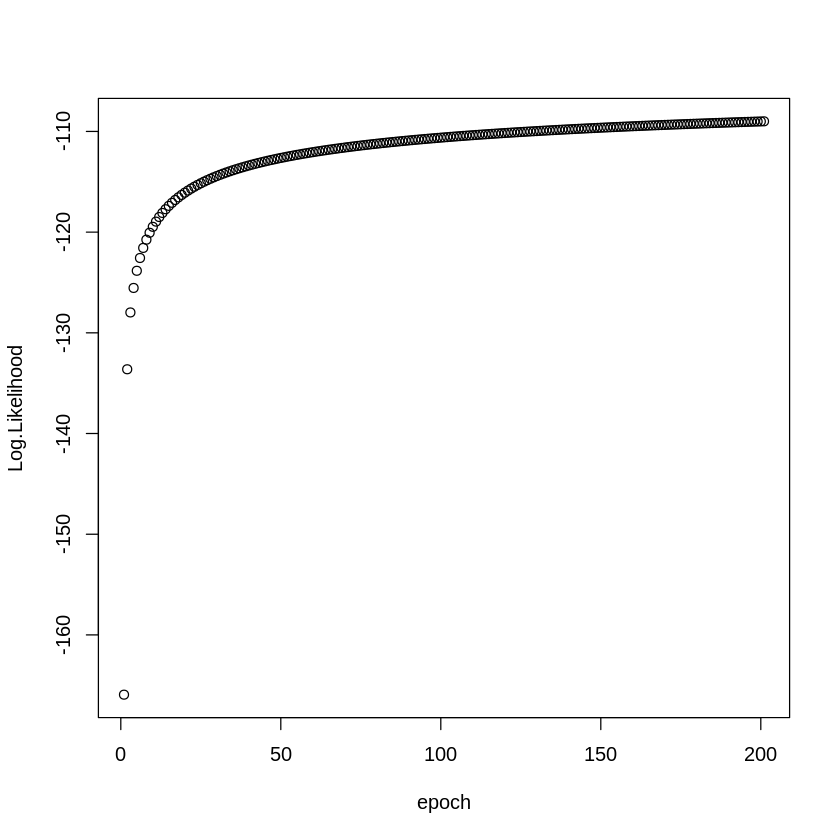

In [135]:
plot(LL,xlab =  "epoch", ylab ="Log.Likelihood")

In [12]:
alpha/sum(alpha)

0.2107065,0.347816,0.05238848,0.1250369,0.03458392,0.04124992,0.01131071,0.1644799,0.01242768


In [21]:
alpha

10.70914,17.67772,2.662641,6.354994,1.757725,2.096524,0.5748662,8.359679,0.6316361


# evaluate confidence range

In [87]:
high_boundary <- matrix(1,1,cell.type.number)
low_boundary <- matrix(1,1,cell.type.number)

for(i in 1: cell.type.number){
    Second.derivative.i <- 0
    for(sample in 1:dim(Xs)[1]){
        K <- Ks[sample,]
        X <- Xs[sample,]
        Second.derivative.i <- Second.derivative.i + trigamma(sum(alpha))-trigamma(sum(alpha)+sum(X))+trigamma(X[i]+alpha[i])-trigamma(alpha[i])
    }
        high_boundary[i] <- alpha[i] + 1.96/sqrt(-1*Second.derivative.i)
        low_boundary[i] <- max(alpha[i] - 1.96/sqrt(-1*Second.derivative.i),0)
}

In [88]:
result <- as.data.frame(rbind(as.double(high_boundary),alpha,as.double(low_boundary)))
row.names(result)<- c("high_boundary","estimated_alpha","low_boundary")

In [89]:
result/sum(result[2,])

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high_boundary,0.3210410,0.5182654,0.10302594,0.21120513,0.07505020,0.08545173,0.03117436,0.26019156,0.03431599
estimated_alpha,0.2107065,0.3478160,0.05238848,0.12503694,0.03458392,0.04124992,0.01131071,0.16447989,0.01242768
low_boundary,0.1003720,0.1773665,0.00175102,0.03886874,0.00000000,0.00000000,0.00000000,0.06876823,0.00000000


# Class version

In [2]:
MDMM <- R6Class("MDMM",
  # public methods and parameters
  public = list(
  initialize = function(){},
      
  fit = function(Xs,Ks,intial.alpha=NULL, max.iter=200, threshold=0.001, learning.rate=0.1){
      
      ## input
      ## Xs: group of count vectors
      ## Ks: group of mask vectors
      ## Initial_alpha: the initial value of alpha, can be a vector, the default value is the mean value of all Xs
      
      ###### parameter validation ######
      if (!sum(dim(Xs)==dim(Ks))==2){
          print("Error! The dimension of input Xs and Ks must be same.")
          return(-1)
      }
      if (!is.null(intial.alpha) && !dim(Xs)[2]==length(intial.alpha)){
          print("Error! The column dimension of input Xs and the length of intial.alpha must be same.")
          return(-1)
      }
      
      ###### parameter initialize ######
      private$dims = dim(Xs)[2]
      private$learning_rate <- learning.rate
      private$max_iter <- max.iter
      private$threshold <- threshold
      
      if(is.null(intial.alpha)){
          initial.alpha <- colMeans(Xs)
      }
      private$initial_alpha <- initial.alpha
      alpha <- initial.alpha
    
      private$LL_list <- c(private$log.Likelihood(alpha,Xs,Ks))
      
      ###### estimation ######
      for(epoch in 1:private$max_iter){
        for(sample in 1:dim(Xs)[1]){
            gradient.alpha <- matrix(0, private$dims, 1)
            K <- Ks[sample,]
            X <- Xs[sample,]

            for(j in 1: private$dims){
                if(K[j]==1){
                    gradient.alpha[j] <- digamma(sum(alpha))-digamma(sum(alpha)+sum(X))+digamma(X[j]+alpha[j])-digamma(alpha[j])
                }
            }
            alpha <- alpha + learning_rate * as.double(gradient.alpha)
        }
        if(abs(private$LL_list[length(private$LL_list)]-private$log.Likelihood(alpha,Xs,Ks))<= private$threshold){
            break
        }else{
            private$LL_list <- c(private$LL_list, private$log.Likelihood(alpha,Xs,Ks))
        }  
    }
    
      ###### confidence range ######
      high_boundary <- matrix(1,1,private$dims)
      low_boundary <- matrix(1,1,private$dims)
  
      for(i in 1: private$dims){
          Second.derivative.i <- 0
          for(sample in 1:dim(Xs)[1]){
              K <- Ks[sample,]
              X <- Xs[sample,]
              Second.derivative.i <- Second.derivative.i + trigamma(sum(alpha))-trigamma(sum(alpha)+sum(X))+trigamma(X[i]+alpha[i])-trigamma(alpha[i])
          }
              high_boundary[i] <- alpha[i] + 1.96/sqrt(-1*Second.derivative.i)
              low_boundary[i] <- max(alpha[i] - 1.96/sqrt(-1*Second.derivative.i),0)
      }
      
      
      ###### save result ######
      result <- as.data.frame(rbind(as.double(high_boundary),alpha,as.double(low_boundary)))
      row.names(result)<- c("high_boundary","estimated_alpha","low_boundary")
      private$estimation <- result 
  },
      
      
  get_parameters = function(){
      print(paste("dims:",private$dims))
      print(paste("learning_rate:",private$learning_rate))
      print(paste("max_iter:",private$max_iter))
      print(paste("threshold:",private$threshold))
  },
  get_result = function(){return(private$estimation)},
  draw_trainning_process = function(){plot(private$LL_list,xlab =  "epoch", ylab ="Log.Likelihood")}
  ), 
                
  
  private = list(
      ## private parameters
      dims = NULL,
      learning_rate = NULL,
      initial_alpha = NULL,
      threshold = NULL,
      max_iter = NULL,
      
      estimation = NULL,
      LL_list = NULL,
      
      ## private methods
      log.Likelihood = function(alpha,Xs,Ks){
        Likelihood <- 0
        for(i in 1:dim(Xs)[1]){
            K_i <- Ks[i,]
            X_i <- as.double(Xs[i,K_i==1])
            alpha_i <- as.double(alpha[K_i==1])

            Likelihood <- Likelihood + log(gamma(sum(alpha_i))) - log(gamma(sum(alpha_i+X_i)))
            for(j in 1:length(alpha_i)){
                Likelihood <- Likelihood + log(gamma(alpha_i[j] + X_i[j])/gamma(alpha_i[j]))
            }
        }
        return(Likelihood)
    }
  )
)

## test class

In [7]:
my_model <- MDMM$new()

In [10]:
my_model$fit(Xs,Ks,max.iter=300)

In [11]:
my_model$get_parameters()

[1] "dims: 9"
[1] "learning_rate: 0.1"
[1] "max_iter: 300"
[1] "threshold: 0.001"


In [13]:
my_model$get_result()

,Endothelial.cell,Cardiomyocyte.cell,Myelocyte,Fibroblast,Lymphocyte,Smooth.muscle.cell,Neuron,Pericyte,Adipocyte
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
high_boundary,20.932772,34.00253,6.53940702,13.652929,4.701495,5.393675,1.9362897,16.880578,2.1185138
estimated_alpha,13.702423,22.73247,3.27736722,8.036780,2.125683,2.557697,0.6735758,10.625953,0.7382738
low_boundary,6.472074,11.46240,0.01532741,2.420631,0.000000,0.000000,0.0000000,4.371329,0.0000000


In [14]:
write.csv(my_model$get_result(),paste0("/stor/public/chenyx/HHCAd/DM_result2/subregion/","LV.csv"))

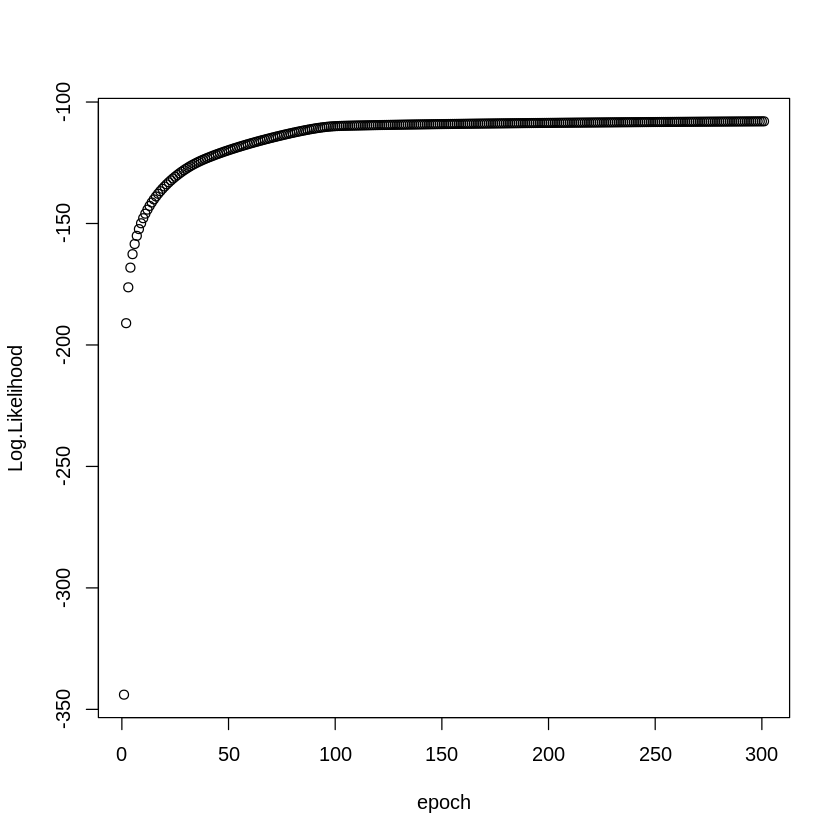

In [151]:
my_model$draw_trainning_process()